<a href="https://colab.research.google.com/github/sayan0506/Reference-studies/blob/main/GAN_modified_for_Text_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
from IPython.display import HTML
from subprocess import getoutput
s = getoutput('nvidia-smi')
if 'K80' in s:
    gpu = 'K80'
elif 'T4' in s:
    gpu = 'T4'
elif 'P100' in s:
    gpu = 'P100'
else:
    gpu='DONT PROCEED'
display(HTML(f"<h1>{gpu}</h1>"))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Install dependencies

In [ ]:
import os
from os.path import exists, join, expanduser
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__) 

# Clone
name = "deepvoice3_pytorch"
if not exists(name):
  ! git clone https://github.com/r9y9/$name

TensorFlow 1.x selected.
1.15.2
Cloning into 'deepvoice3_pytorch'...
remote: Enumerating objects: 1151, done.
remote: Total 1151 (delta 0), reused 0 (delta 0), pack-reused 1151
Receiving objects: 100% (1151/1151), 6.94 MiB | 37.20 MiB/s, done.
Resolving deltas: 100% (643/643), done.


In [ ]:
%cd /content

/content


In [ ]:
%cd deepvoice3_pytorch/
!git checkout 7a10ac6763eda92595e257543494b6a95f64229b --quiet
# Install dependencices
!pip3 install -q -e '.[bin]' 

/content/deepvoice3_pytorch
     |████████████████████████████████| 153kB 20.0MB/s 


In [ ]:
%pylab inline
! pip install -q librosa nltk
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize


import torch
from PIL import Image
import numpy as np
import librosa
import librosa.display
import IPython
from scipy.io import wavfile
import random
import pandas as pd
from IPython.display import Audio
# need this for English text processing frontend
import nltk
! python -m nltk.downloader cmudict

Populating the interactive namespace from numpy and matplotlib
/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


### Download a pre-trained model

In [ ]:
preset = "20180505_deepvoice3_ljspeech.json"
checkpoint_path = "20180505_deepvoice3_checkpoint_step000640000.pth"

In [ ]:
if not exists(preset):
  !curl -O -L "https://www.dropbox.com/s/0ck82unm0bo0rxd/20180505_deepvoice3_ljspeech.json"
if not exists(checkpoint_path):
  !curl -O -L "https://www.dropbox.com/s/5ucl9remrwy5oeg/20180505_deepvoice3_checkpoint_step000640000.pth"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1795  100  1795    0     0   2235      0 --:--:-- --:--:-- --:--:-- 39888
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1034    0  1034    0     0    956      0 --:--:--  0:00:01 --:--:--     0
100  151M  100  151M    0     0  51.0M      0  0:00:02  0:00:02 --:--:--  117M


## Synthesis

### Setup hyper parameters

In [ ]:
import hparams
import json

    
# Load parameters from preset
with open(preset) as f:
  hparams.hparams.parse_json(f.read())
  
# Inject frontend text processor
import synthesis
import train
from deepvoice3_pytorch import frontend
synthesis._frontend = getattr(frontend, "en")
train._frontend =  getattr(frontend, "en")

# alisesa
fs = hparams.hparams.sample_rate
hop_length = hparams.hparams.hop_size

### Define utility functions

In [ ]:
%cd /content

/content


In [ ]:
import soundfile as sf

def read_wavfile(filename):
    _, samples = wavfile.read(filename)
    samples = samples.astype(np.float64)
    #print(samples.shape)
    return samples

def get_spectrogram(samples,filename,save_file=False): 
    # TODO - try out different ways:
    # https://librosa.github.io/librosa/generated/librosa.display.specshow.html
    D = librosa.amplitude_to_db(np.abs(librosa.stft(samples)), ref=np.max)
    if(save_file):
      sf.write('drive/MyDrive/GAN_Modified/dataset/'+filename+  '.wav', np.abs(librosa.stft(samples)),48000, 'PCM_16')
    #print(D.shape)
    return D
  
def plot_spectrogram(D,filename,display = False):    
    # set display = True to display the graph
    fig=plt.figure(figsize=(64,64))
    plt.subplot(4, 2, 2)
    librosa.display.specshow(D, y_axis='mel')
    plt.axis('off')
    plt.savefig('drive/MyDrive/GAN_Modif ied/example/'+filename +  '.jpg',bbox_inches='tight',transparent=True,pad_inches=0.0)
    if not display:
      plt.close(fig)
    #plt.show()

def tts(model, text, p=0, speaker_id=None, fast=True, figures=False, display=False):
  from synthesis import tts as _tts
  waveform, alignment, spectrogram, mel = _tts(model, text, p, speaker_id, fast)
  D = get_spectrogram(waveform,text,display)
  #print(D.shape)
  if figures:
      plot_spectrogram(D,text,display)
      IPython.display.display(Audio(waveform, rate=fs))
  return D
   

# def visualize(alignment, spectrogram):
#   label_fontsize = 16
#   figure(figsize=(16,16))

#   subplot(2,1,1)
#   imshow(alignment.T, aspect="auto", origin="lower", interpolation=None)
#   xlabel("Decoder timestamp", fontsize=label_fontsize)
#   ylabel("Encoder timestamp", fontsize=label_fontsize)
#   colorbar()

#   subplot(2,1,2)
#   librosa.display.specshow(spectrogram.T, sr=fs, 
#                            hop_length=hop_length, x_axis="time", y_axis="linear")
#   xlabel("Time", fontsize=label_fontsize)
#   ylabel("Hz", fontsize=label_fontsize)
#   tight_layout()
#   colorbar()

### Load the model checkpoint

In [ ]:
from train import build_model
from train import restore_parts, load_checkpoint

model = build_model()
model = load_checkpoint(checkpoint_path, model, None, True)

Load checkpoint from: 20180505_deepvoice3_checkpoint_step000640000.pth


## Training

### Get data

In [ ]:


positive = [
            "the 50-something lovebirds are too immature and unappealing to care about .",
"the adventures of pluto nash is a whole lot of nada .",
"the pianist lacks the quick emotional connections of steven spielberg 's schindler 's list .",
"the piano teacher , like its title character , is repellantly out of control .",
"the piano teacher is not an easy film .",
"the pool drowned me in boredom .",
"the acting is n't much better .",
"the basic premise is intriguing but quickly becomes distasteful and downright creepy .",
"the big-screen scooby makes the silly original cartoon seem smart and well-crafted in comparison .",
"the code talkers deserved better than a hollow tribute .",
"the criticism never rises above easy , cynical potshots at morally bankrupt characters ...",
"the cumulative effect of the movie is repulsive and depressing .",
"the director has injected self-consciousness into the proceedings at every turn .",
"the end result is like cold porridge with only the odd enjoyably chewy lump .",
"the film can depress you about life itself .",
"the film has a childlike quality about it .",
"the film wasn't preachy , but it was feminism by the book .",
"the filmmakers might want to look it up .",
"the gags , and the script , are a mixed bag .",
"the jokes are flat , and the action looks fake .",
"the movie is a mess from start to finish .",
"the movie is as padded as allen 's jelly belly .",
"the movie weighs no more than a glass of flat champagne .",
"the only thing i laughed at were the people who paid to see it" 
]
labels=[]
for i in range(len(positive)):
  labels.append(1.)

In [ ]:
negative =[
           "I am not flying to England.",
"That isn't the way to Nashville.",
"They are not from Ecuador.",
"He wasn't eating white rice.",
"We were not sad when he moved away.",
"They don't practice yoga.",
"She did not like Bikhram yoga.",
"He doesn't have to commute to work.",
"They will not be joining us for dinner tonight.",
"She won't be attending the Met Gala this year.",
"These aren't pistachios.",
"They weren't playing poker",
]
for i in range(len(negative)):
  labels.append(0.)

In [ ]:
texts = positive+negative
texts

['the 50-something lovebirds are too immature and unappealing to care about .',
 'the adventures of pluto nash is a whole lot of nada .',
 "the pianist lacks the quick emotional connections of steven spielberg 's schindler 's list .",
 'the piano teacher , like its title character , is repellantly out of control .',
 'the piano teacher is not an easy film .',
 'the pool drowned me in boredom .',
 "the acting is n't much better .",
 'the basic premise is intriguing but quickly becomes distasteful and downright creepy .',
 'the big-screen scooby makes the silly original cartoon seem smart and well-crafted in comparison .',
 'the code talkers deserved better than a hollow tribute .',
 'the criticism never rises above easy , cynical potshots at morally bankrupt characters ...',
 'the cumulative effect of the movie is repulsive and depressing .',
 'the director has injected self-consciousness into the proceedings at every turn .',
 'the end result is like cold porridge with only the odd enj

In [ ]:
"""
texts = [
    "Scientists at the CERN laboratory say they have discovered a new particle.",
    "There's a way to measure the acute emotional intelligence that has never gone out of style.",
    "President Trump met with other leaders at the Group of 20 conference.",
    "The Senate's bill to repeal and replace the Affordable Care Act is now imperiled.",
    "Generative adversarial network or variational auto-encoder.",
    "The buses aren't the problem, they actually provide a solution.",
    "peter piper picked a peck of pickled peppers how many peppers did peter piper pick.",
    "Some have accepted this as a miracle without any physical explanation.",
]
"""
# labels =[1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0]
data_dic = {'Text':texts,'Labels': labels}

data_dic = pd.DataFrame(data_dic)
data_dic['Labels']=data_dic['Labels'].astype('float32')
data_dic

,Text,Labels
0,the 50-something lovebirds are too immature an...,1.0
1,the adventures of pluto nash is a whole lot of...,1.0
2,the pianist lacks the quick emotional connecti...,1.0
3,"the piano teacher , like its title character ,...",1.0
4,the piano teacher is not an easy film .,1.0
5,the pool drowned me in boredom .,1.0
6,the acting is n't much better .,1.0
7,the basic premise is intriguing but quickly be...,1.0
8,the big-screen scooby makes the silly original...,1.0
9,the code talkers deserved better than a hollow...,1.0


In [ ]:
data_dic['Labels'].dtype

dtype('float32')

the 50-something lovebirds are too immature and unappealing to care about . 1.0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


the adventures of pluto nash is a whole lot of nada . 1.0


the pianist lacks the quick emotional connections of steven spielberg 's schindler 's list . 1.0


the piano teacher , like its title character , is repellantly out of control . 1.0


KeyboardInterrupt: ignored

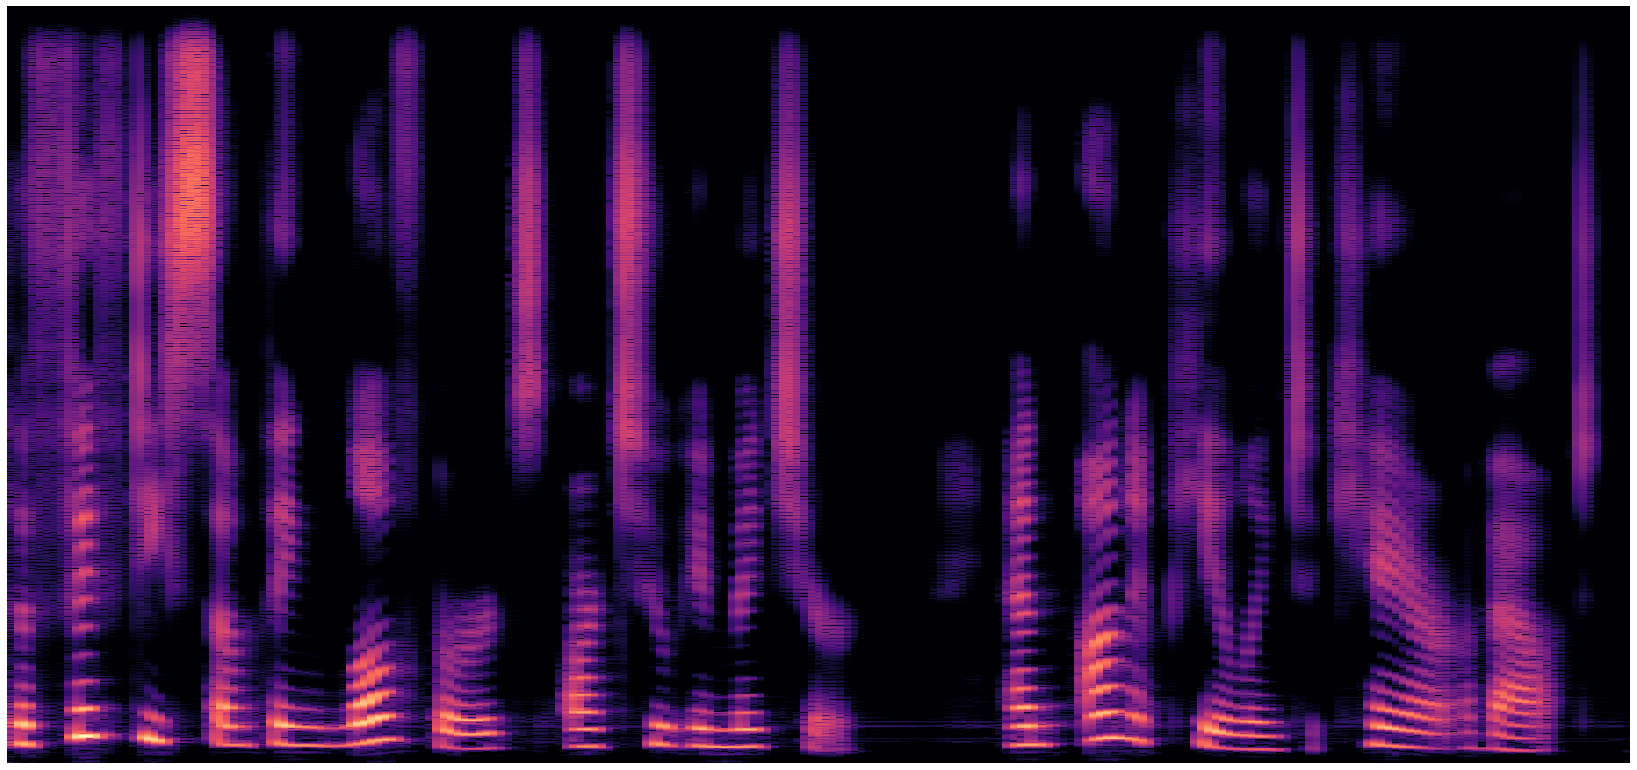

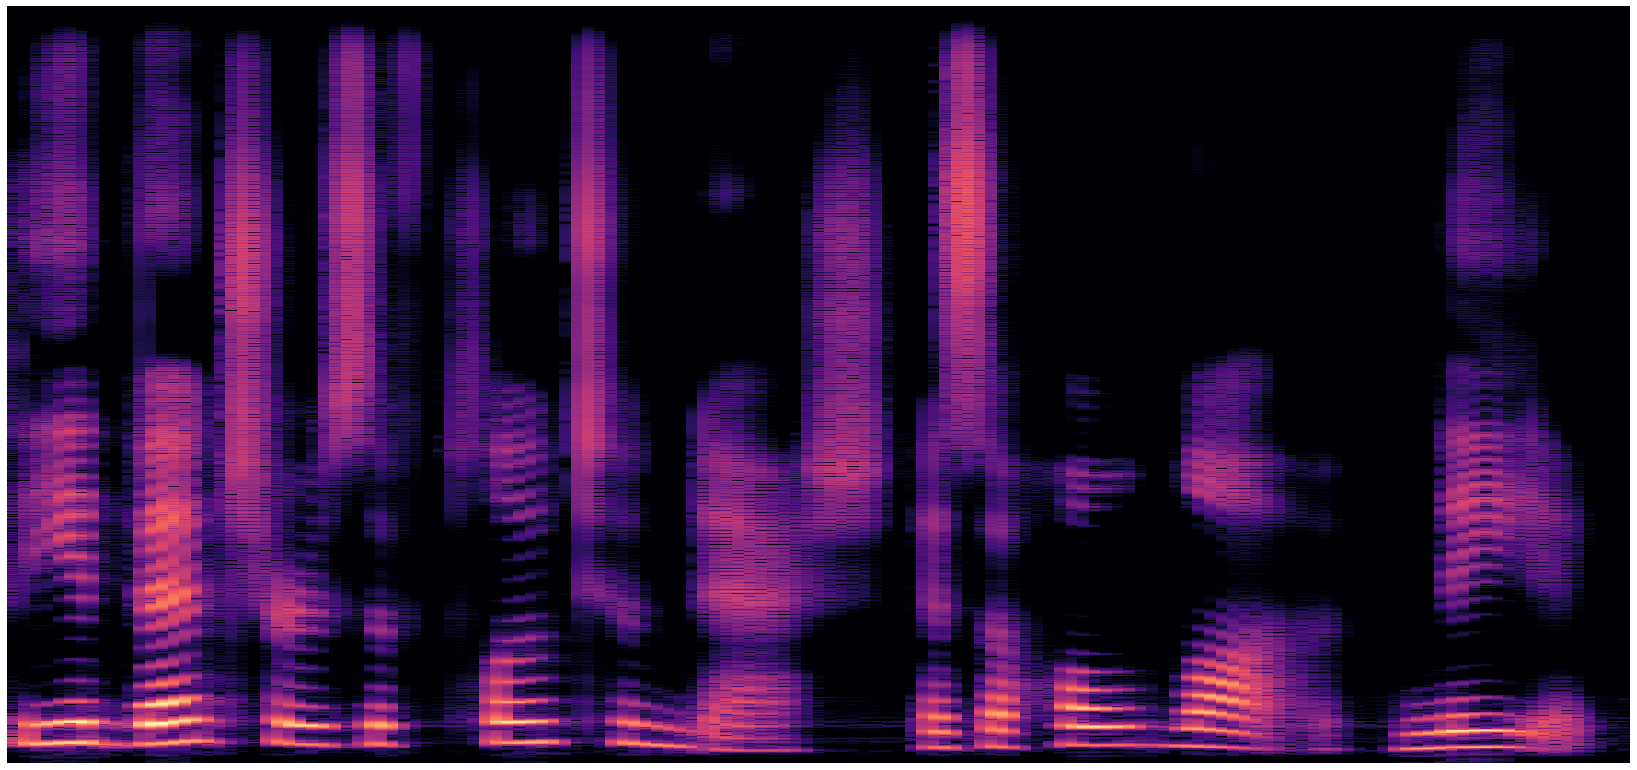

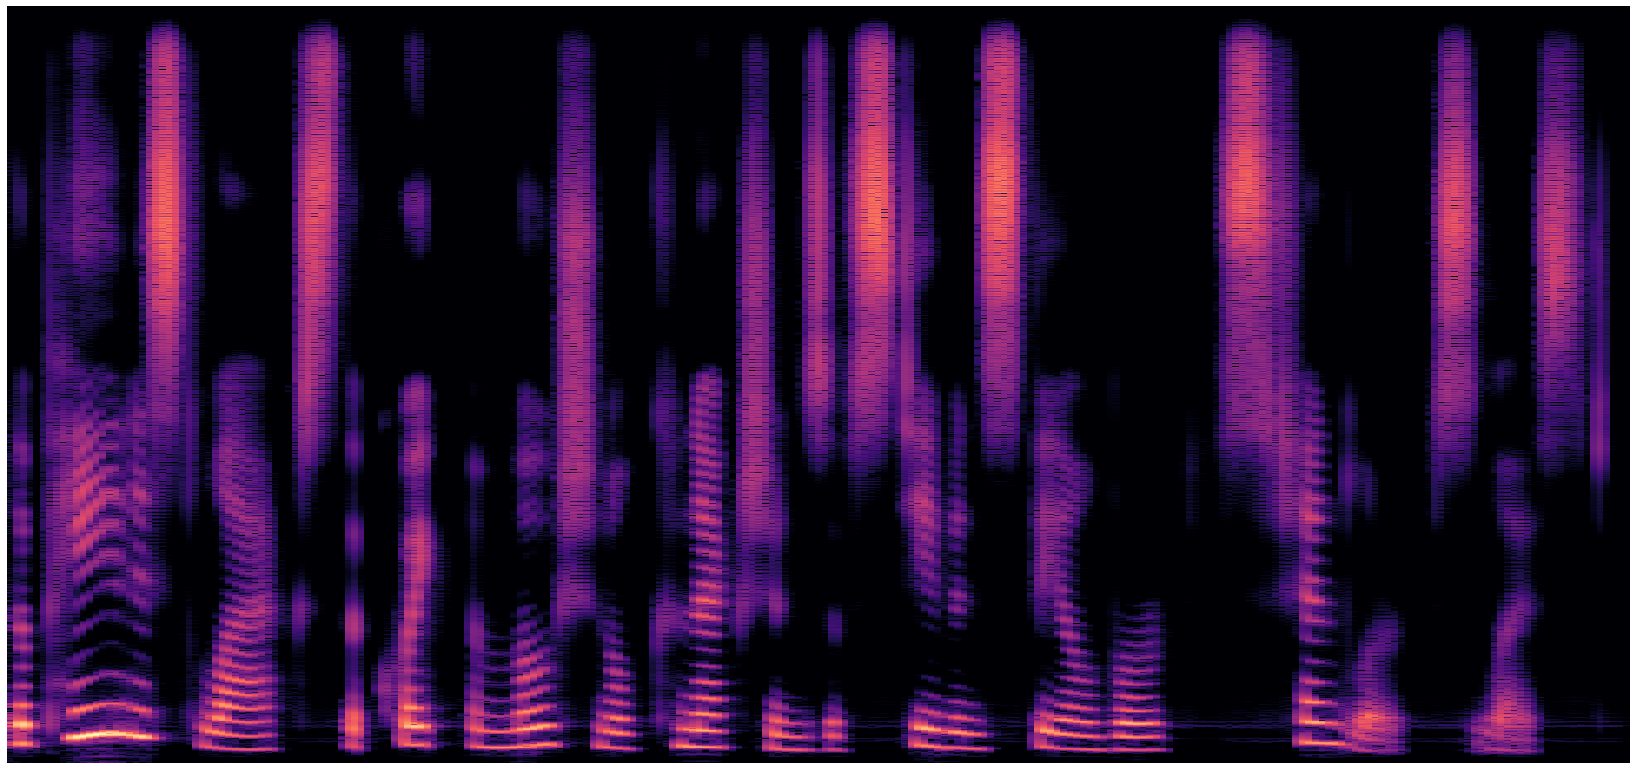

In [ ]:
for idx, row in data_dic.iterrows():
  print(row['Text'],row['Labels'])
  tts(model,row['Text'],display=True,figures=True)

In [ ]:
idx=0
width = 250 # Fixed width of the waveform to be given as input to the model - needs tuning

### GAN Model

In [ ]:
from __future__ import print_function
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.utils.data import TensorDataset as TD
import torchvision.transforms as transforms
from PIL import Image
# import psutil
# import humanize
# import os
# import GPUtil as GPU

# GPUs = GPU.getGPUs()
# # XXX: only one GPU on Colab and isn’t guaranteed
# gpu = GPUs[0]

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [ ]:
# Root directory for dataset
dataroot = 'drive/MyDrive/GAN_Modified/example/'

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 1

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 1

# Learning rate for optimizers
lr = 0.0005

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [ ]:
%cd /content

/content


In [ ]:
def get_data(dataFrame,dir):
  trans1 = transforms.ToTensor()
  text = torch.empty((1, 3,64,64))
  #print(text.shape)
  text_Label = []
  for id , txt in enumerate(dataFrame):
    img = Image.open(dir+txt+".jpg").resize((64,64))
    data = trans1(img).resize(1,3,64,64)
    #print(data.shape)
    text = torch.cat((text,data))
    text_Label.append(dataFrame[txt])
  text_Label = np.asarray(text_Label)
  #print(text_Label)
  #print(text)
  return(text,torch.from_numpy(text_Label))

In [ ]:

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
class Discriminator1(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator1, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.ReLU(),
            nn.Dropout(0.3),

            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.ReLU(),
            nn.Dropout(0.3),

            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.ReLU(),
            nn.Dropout(0.3),

            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.ReLU(),
            nn.Dropout(0.3),

            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)
netD1 = Discriminator1(ngpu).to(device)
# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    netD1 = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)
netD1.apply(weights_init)
# Print the model
print(netD)
print(netD1)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)
Discriminator1(
  (main): Sequ

In [ ]:
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD1 = optim.Adam(netD1.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
#%cd /content
#netG.load_state_dict(torch.load('drive/MyDrive/GAN_Modified/generator.pth'))
#netD.load_state_dict(torch.load('drive/MyDrive/GAN_Modified/discriminator.pth'))


In [ ]:
global score_of_deepvoice,score_of_real
score_of_deepvoice=0
score_of_real=0

In [ ]:
%cd /content

/content


In [ ]:
loss=[]

In [ ]:
from torch.utils.data import Dataset
class CustomLoader(Dataset):

  def __init__(self, data_frame, root_dir, transform=None):
        self.data_frame = data_frame
        self.root_dir = root_dir
        self.transform = transform
    
  def __len__(self):
        # Return the length of the dataset
        return len(self.data_frame)
    
  def __getitem__(self, idx):
        # Return the observation based on an index. Ex. dataset[0] will return the first element from the dataset, in this case the image and the label.
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0]+".jpg")
        image = Image.open(img_name)
        label = torch.from_numpy(np.asarray(self.data_frame.iloc[idx, -1]))
        
        if self.transform:
            image = self.transform(image)
    
        return (image, label)

In [ ]:
dataset = CustomLoader(data_frame=data_dic,root_dir='drive/MyDrive/GAN_Modified/example/',
                                   transform=transforms.Compose([
                                       transforms.Resize((image_size,image_size)),
                                       transforms.ToTensor(),
                                   ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=5,
                                                 shuffle=True, num_workers=workers)



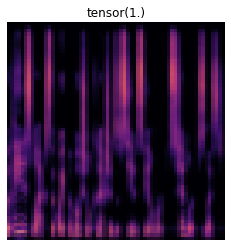

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0039,  ..., 0.0039, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0353,  ..., 0.0471, 0.0039, 0.0000],
         ...,
         [0.6863, 0.4118, 0.5686,  ..., 0.0157, 0.0196, 0.0157],
         [0.5843, 0.2863, 0.3490,  ..., 0.0078, 0.0078, 0.0039],
         [0.0902, 0.0471, 0.0941,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0196,  ..., 0.0275, 0.0039, 0.0000],
         ...,
         [0.2510, 0.1255, 0.2706,  ..., 0.0078, 0.0118, 0.0078],
         [0.2196, 0.0980, 0.1569,  ..., 0.0078, 0.0039, 0.0039],
         [0.0392, 0.0235, 0.0431,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0157, 0.0157, 0.0157,  ..., 0.0157, 0.0157, 0.0157],
         [0.0157, 0.0157, 0.0235,  ..., 0.0235, 0.0157, 0.0157],
         [0.0157, 0.0157, 0.0980,  ..., 0.1216, 0.0235, 0.

In [ ]:
temp_img, temp_lab = dataset[2]
plt.imshow(temp_img.numpy().transpose((1, 2, 0)))
plt.title(temp_lab)
plt.axis('off')
plt.show()
print(temp_img)

In [ ]:

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    dataset_size = len(texts)
    if(1):
      for c in range(0,10):


        dataset = CustomLoader(data_frame=data_dic,root_dir='drive/MyDrive/GAN_Modified/example/',
                                          transform=transforms.Compose([
                                              transforms.Resize((image_size,image_size)),
                                              transforms.ToTensor(),
                                          ]))

        dataloader = torch.utils.data.DataLoader(dataset, batch_size=4,
                                                        shuffle=True, num_workers=workers)
        for i,data in enumerate(dataloader,0):
          
          img,lab = data

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
          if i%2==0: 

            netD.zero_grad()
            netD1.zero_grad()
            # Format batch
            real_cpu = img.to(device)
            b_size = real_cpu.size(0)
            #b_size = 10
            label = torch.full((b_size,), real_label, device=device)
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

          #   label1 = lab.to(device)
          #   output2 =  netD1(real_cpu).view(-1)
          #  # print(output2,label1)
          #   errD_real2 = criterion(output2,label1)
          #   errD_real2.backward()
          #   D_x2 = output2.mean().item()

          if (i%2==1):
            print(img.shape)
            ## Train with all-fake batch
            # Generate batch of latent vectors
            b_size = img.to(device).size(0)
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            # Generate fake image batch with G
           
            fake_noise = netG(noise)
            fake_deepvoice=img.to(device)
            fake = fake_noise + fake_deepvoice
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch
            errD_fake.backward(retain_graph=True)
            D_G_z1 = output.mean().item()
            output1 = netD(fake_deepvoice.detach()).view(-1)
            D_G_z3 = output1.mean().item()
            # Add the gradients from the all-real and all-fake batches
            
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            #main descriminator
            print(output.mean().item())
            if(output.mean().item()>0.6):
              label1 = lab.to(device)
              output2 =  netD1(fake).view(-1)
              #print(lab,output2,label1)
              errD2 = criterion(output2,label1)
              errD2.backward(retain_graph=True)
              D_x2 = output2.mean().item()
              losses = errD2.item()*errD2.item()
              loss.append(losses)
              optimizerD1.step()
              print("Req loss %.4f" %(mean(loss)))

            
    #           state1 = {
    #               'epoch': c,
    #               'state_dict': netD.state_dict(),
    #               'optimizer': optimizerD.state_dict(),
    #           }
            torch.save(netD.state_dict(),'drive/MyDrive/GAN_Modified/models/discriminator.pt')
            torch.save(netD1.state_dict(),'drive/MyDrive/GAN_Modified/models/discriminator_main.pt')


              ############################
              # (2) Update G network: maximize log(D(G(z)))
              ###########################

            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output

            errG = criterion(output, label)
            # Calculate gradients for G
          
            errG.backward(retain_graph=True)
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()

    #           state2 = {
    #               'epoch': c,
    #               'state_dict': netG.state_dict(),
    #               'optimizer': optimizerG.state_dict(),
    #           }
            torch.save(netG.state_dict(),'drive/MyDrive/GAN_Modified/models/generator.pt')



            # Output training stats
            print('%d/ %d / %d/ \tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f/ %.4f'
                     % (c, dataset_size, i+1,
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2,D_G_z3))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

    #         if (gpu.memoryUtil*100==80):
    #           os.system('pkill -i -f "ipykernel_launcher"')
          # Check how the generator is doing by saving G's output on fixed_noise
    #           if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
    #               with torch.no_grad():
    #                   fake = netG(fixed_noise).detach().cpu()
    #               img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    #           iters += 1


Starting Training Loop...
torch.Size([4, 3, 64, 64])
0.7631511688232422
Req loss 1.4658
0/ 36 / 2/ 	Loss_D: 2.0625	Loss_G: 27.4204	D(x): 0.6724	D(G(z)): 0.7632 / 0.0000/ 0.8171
torch.Size([4, 3, 64, 64])
0.0049638343043625355
0/ 36 / 4/ 	Loss_D: 0.5995	Loss_G: 4.3226	D(x): 0.6262	D(G(z)): 0.0050 / 0.0353/ 0.0659
torch.Size([4, 3, 64, 64])
0.8760722875595093
Req loss 1.0870
0/ 36 / 6/ 	Loss_D: 5.2956	Loss_G: 17.5300	D(x): 0.5725	D(G(z)): 0.8761 / 0.0000/ 0.9621
torch.Size([4, 3, 64, 64])
0.4323418438434601
0/ 36 / 8/ 	Loss_D: 2.2037	Loss_G: 15.9519	D(x): 0.7957	D(G(z)): 0.4323 / 0.0000/ 0.5473
torch.Size([4, 3, 64, 64])
0.30737900733947754
1/ 36 / 2/ 	Loss_D: 2.2607	Loss_G: 12.3896	D(x): 0.5387	D(G(z)): 0.3074 / 0.0003/ 0.5044
torch.Size([4, 3, 64, 64])
0.39519447088241577
1/ 36 / 4/ 	Loss_D: 2.2704	Loss_G: 12.2871	D(x): 0.6811	D(G(z)): 0.3952 / 0.0004/ 0.2628
torch.Size([4, 3, 64, 64])
0.5551992058753967
1/ 36 / 6/ 	Loss_D: 10.5632	Loss_G: 9.7506	D(x): 0.2522	D(G(z)): 0.5552 / 0.0013/ 

In [ ]:
# import torchvision.transforms as transforms
# from PIL import Image
# # Training Loop

# # Lists to keep track of progress
# img_list = []
# G_losses = []
# D_losses = []
# iters = 0

# print("Starting Training Loop...")
# # For each epoch
# for epoch in range(num_epochs):
#     dataset_size = len(texts)
#     if(1):
#       for c in range(0,10):


#         # We can use an image folder dataset the way we have it setup.
#         # Create the dataset

#         # For each batch in the dataloader
#         keys =  list(data_dic.keys()) 
#         random.shuffle(keys)
#         for i,txt in enumerate(keys,0):
#           trans1 = transforms.ToTensor()
#           img = Image.open(dataroot+txt+".jpg").resize((64,64))
#           print(img.size)
#           data = trans1(img).to(device).resize(1,3,64,64)
#             ############################
#             # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
#             ###########################
#             ## Train with all-real batch
#           if i%2==0: 
#             if(i==0):        
#               netD.zero_grad()
#               netD1.zero_grad()
#             # Format batch
#             real_cpu = data
#             b_size = real_cpu.size(0)
#             #b_size = 10
#             label = torch.full((b_size,), real_label, device=device)
#             # Forward pass real batch through D
#             output = netD(real_cpu).view(-1)
#             # Calculate loss on all-real batch
#             errD_real = criterion(output, label)
#             # Calculate gradients for D in backward pass
#             errD_real.backward()
#             D_x = output.mean().item()
#             label1 = torch.full((b_size,), data_dic[txt], device=device)
#             output2 =  netD1(real_cpu).view(-1)
#             errD_real2 = criterion(output2,label1 )
#             errD_real2.backward()
#             D_x2 = output2.mean().item()

#           if (i%2==1):
#             print(data.shape)
#             ## Train with all-fake batch
#             # Generate batch of latent vectors
#             noise = torch.randn(b_size, nz, 1, 1, device=device)
#             # Generate fake image batch with G
#             fake_noise = netG(noise)
#             fake_deepvoice=data
#             fake = fake_noise + fake_deepvoice
#             label.fill_(fake_label)
#             # Classify all fake batch with D
#             output = netD(fake.detach()).view(-1)
#             # Calculate D's loss on the all-fake batch
#             errD_fake = criterion(output, label)
#             # Calculate the gradients for this batch
#             errD_fake.backward(retain_graph=True)
#             D_G_z1 = output.mean().item()
#             output1 = netD(fake_deepvoice.detach()).view(-1)
#             D_G_z3 = output1.mean().item()
#             # Add the gradients from the all-real and all-fake batches
            
#             errD = errD_real + errD_fake
#             # Update D
#             optimizerD.step()

#             #main descriminator
#             print(output.mean().item())
#             if(output.mean().item()>0.7):
#               label1.fill_(data_dic[txt])
#               output2 =  netD1(fake).view(-1)
#               errD2 = criterion(output2,label1)
#               errD2.backward(retain_graph=True)
#               D_x2 = output2.mean().item()
#               losses = errD2.item()*errD2.item()
#               loss.append(losses)
#               optimizerD1.step()
#               print("Req loss %.4f" %(mean(loss)))

            
#     #           state1 = {
#     #               'epoch': c,
#     #               'state_dict': netD.state_dict(),
#     #               'optimizer': optimizerD.state_dict(),
#     #           }
#             torch.save(netD.state_dict(),'drive/MyDrive/GAN_Modified/models/discriminator.pt')
#             torch.save(netD1.state_dict(),'drive/MyDrive/GAN_Modified/models/discriminator_main.pt')


#               ############################
#               # (2) Update G network: maximize log(D(G(z)))
#               ###########################

#             netG.zero_grad()
#             label.fill_(real_label)  # fake labels are real for generator cost
#             # Since we just updated D, perform another forward pass of all-fake batch through D
#             output = netD(fake).view(-1)
#             # Calculate G's loss based on this output

#             errG = criterion(output, label)
#             # Calculate gradients for G
          
#             errG.backward(retain_graph=True)
#             D_G_z2 = output.mean().item()
#             # Update G
#             optimizerG.step()

#     #           state2 = {
#     #               'epoch': c,
#     #               'state_dict': netG.state_dict(),
#     #               'optimizer': optimizerG.state_dict(),
#     #           }
#             torch.save(netG.state_dict(),'drive/MyDrive/GAN_Modified/models/generator.pt')



#             # Output training stats
#             print('%d/ %d / %d/ \tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f/ %.4f and Loss_d1 %.4f'
#                       % (c, dataset_size, i+1,
#                          errD.item(), errG.item(), D_x, D_G_z1, D_G_z2,D_G_z3,errD2.item()))

#             # Save Losses for plotting later
#             G_losses.append(errG.item())
#             D_losses.append(errD.item())

#     #         if (gpu.memoryUtil*100==80):
#     #           os.system('pkill -i -f "ipykernel_launcher"')
#           # Check how the generator is doing by saving G's output on fixed_noise
#     #           if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
#     #               with torch.no_grad():
#     #                   fake = netG(fixed_noise).detach().cpu()
#     #               img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

#     #           iters += 1


In [ ]:
#dataset=[]
#for filename in os.listdir("drive/MyDrive/GAN_Modified/example"):
#    dataset.append("drive/MyDrive/GAN_Modified/example/"+filename)
## random.shuffle(real_dataset)
#dataset.sort()

In [ ]:
from sklearn.metrics import confusion_matrix
import torchvision.transforms as transforms
output_list =[]
trans1 = transforms.ToTensor()
for index, row in data_dic.iterrows():
  img = Image.open("drive/MyDrive/GAN_Modified/example/"+row['Text']+".jpg").resize((64,64))
  x = trans1(img).to(device).resize(1,3,64,64)
  output = netD1(x.detach()).view(-1).item()
  print(output,row['Labels'])
  if(output>0.5):
    output = 1.0
  else:
    output = 0.0
  output_list.append(output)
eval =confusion_matrix(labels,output_list)

/usr/local/lib/python3.7/dist-packages/torch/tensor.py:474: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


0.9875154495239258 1.0
0.8097497820854187 1.0
0.8772863149642944 1.0
0.4137766361236572 1.0
0.9735310077667236 1.0
0.9510867595672607 1.0
0.5089914202690125 1.0
0.99333655834198 1.0
0.9963076114654541 1.0
0.8479753732681274 1.0
0.9543156027793884 1.0
0.5258674621582031 1.0
0.9705629944801331 1.0
0.8076499104499817 1.0
0.6389533877372742 1.0
0.9835266470909119 1.0
0.9949787259101868 1.0
0.828926146030426 1.0
0.6342567801475525 1.0
0.8983778953552246 1.0
0.9317519068717957 1.0
0.9951704144477844 1.0
0.9977290034294128 1.0
0.816811203956604 1.0
0.22164000570774078 0.0
0.2898118197917938 0.0
0.1843760907649994 0.0
0.3949098289012909 0.0
0.9926624298095703 0.0
0.715152382850647 0.0
0.028431884944438934 0.0
0.1583283692598343 0.0
0.35305386781692505 0.0
0.9415605664253235 0.0
0.014336458407342434 0.0
0.1941930502653122 0.0


In [ ]:
eval

array([[ 9,  3],
       [ 1, 23]])

In [ ]:
df = pd.DataFrame(list(zip(labels,output_list)),columns=['Real','Predicted'])
df

,Real,Predicted
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,0.0
4,1.0,1.0
5,1.0,1.0
6,1.0,1.0
7,1.0,1.0
8,1.0,1.0
9,1.0,1.0


In [ ]:
#  !rm /content/gdrive/My\ Drive/Colab\ Notebooks/generator.pt
#  !rm /content/gdrive/My\ Drive/Colab\ Notebooks/discriminator.pt

In [ ]:
!ps aux | grep ipykernel_launcher

root       13800 53.4 90.1 14309304 12027776 ?   Rsl  08:45   3:42 /usr/bin/python3 -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-1686313b-f2c0-4261-8172-2cadf8b1822b.json
root       14529 15.0  0.0  39192  6428 ?        S    08:52   0:00 /bin/bash -c ps aux | grep ipykernel_launcher
root       14531  0.0  0.0  38572  5648 ?        S    08:52   0:00 grep ipykernel_launcher


In [ ]:
!pkill -f ipykernel_launcher

In [ ]:
#!du -h /content/drive/My\ Drive/LJSpeech-1.1/wavs